**Further steps:**
- Spot prices - Hacer ARIMA

- ¿Como hago el estudio de parametros para p^f? ¿Me invento los valores?

In [1]:
#pip install pmdarima

In [2]:
# Import the libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.preprocessing import MinMaxScaler
import statsmodels.api as sm
import os
from sklearn.metrics import mean_squared_error
import math
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
#from pmdarima.arima import auto_arima #Descargar
import itertools
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.stats.diagnostic import acorr_ljungbox
from scipy.stats import norm
from sklearn.metrics import mean_absolute_error
from scipy.stats import boxcox
from scipy.special import inv_boxcox
from sklearn.metrics import mean_squared_error
from scipy.stats import lognorm
from scipy.stats import gamma
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler
import warnings

# Hourly price day ahead market

In [3]:
# Import the dataset
price_data = pd.read_csv("price_day_ahead.csv", sep=";")
price_data.head()

,id,name,geoid,geoname,value,datetime
0,805,Hourly average price Day Ahead market component,NaN,NaN,66.88,2019-01-01T00:00:00+01:00
1,805,Hourly average price Day Ahead market component,NaN,NaN,66.88,2019-01-01T01:00:00+01:00
2,805,Hourly average price Day Ahead market component,NaN,NaN,66.00,2019-01-01T02:00:00+01:00
3,805,Hourly average price Day Ahead market component,NaN,NaN,63.64,2019-01-01T03:00:00+01:00
4,805,Hourly average price Day Ahead market component,NaN,NaN,58.85,2019-01-01T04:00:00+01:00


## Data pre-processing and Exploratory Data Analyst (EDA)

In [4]:
# Keep just the important columns, value and datetime
price_data = price_data.iloc[:,[4,5]]

In [5]:
# Get a first impression of the data
price_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43820 entries, 0 to 43819
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   value     43820 non-null  float64
 1   datetime  43820 non-null  object 
dtypes: float64(1), object(1)
memory usage: 684.8+ KB


In [6]:
# Rename the column value
price_data = price_data.rename(columns={'value': 'price'})

In [7]:
# Convert datetime to data type of variable
price_data['datetime'] = pd.to_datetime(price_data['datetime'], utc=True)

# Set the datetime as the index
price_data.set_index("datetime", inplace=True)

In [8]:
# Check for missing values per column
missing = price_data.isna().sum()
columns_with_missing_values = missing[missing>0]
print("Number of columns with missing values:", columns_with_missing_values)
# It does not exist missing data

Number of columns with missing values: Series([], dtype: int64)


In [9]:
# One years collected had 366 days, the rest have 365 so we expect to have 24*365*4 + 366*24 = 43824. However, we get 43820.
# Missing observations are:

# Get the index of the DataFrame
index = price_data.index

# Check for any missing hours in the index
missing_hours = pd.date_range(start=index.min(), end=index.max(), freq='h').difference(index)

# Print the missing hours
print("Missing hours:", missing_hours)

# If we go to the excel these values are not missing. As they are only 4 observations in a datagrame of ~50.000 observations, we will leave it like that.

Missing hours: DatetimeIndex(['2020-10-25 01:00:00+00:00', '2021-10-31 01:00:00+00:00',
               '2022-10-30 01:00:00+00:00', '2023-10-29 01:00:00+00:00'],
              dtype='datetime64[ns, UTC]', freq=None)


In [10]:
# Summary statistics for the variable of interest, electricity.
price_data.describe()

,price
count,43820.000000
mean,89.616421
std,68.978119
min,0.000000
25%,40.970000
50%,62.650000
75%,124.410000
max,700.000000


In [11]:
# Check uniqueness of the data:
price_data.index.unique()
# Same length as before

DatetimeIndex(['2018-12-31 23:00:00+00:00', '2019-01-01 00:00:00+00:00',
               '2019-01-01 01:00:00+00:00', '2019-01-01 02:00:00+00:00',
               '2019-01-01 03:00:00+00:00', '2019-01-01 04:00:00+00:00',
               '2019-01-01 05:00:00+00:00', '2019-01-01 06:00:00+00:00',
               '2019-01-01 07:00:00+00:00', '2019-01-01 08:00:00+00:00',
               ...
               '2023-12-31 13:00:00+00:00', '2023-12-31 14:00:00+00:00',
               '2023-12-31 15:00:00+00:00', '2023-12-31 16:00:00+00:00',
               '2023-12-31 17:00:00+00:00', '2023-12-31 18:00:00+00:00',
               '2023-12-31 19:00:00+00:00', '2023-12-31 20:00:00+00:00',
               '2023-12-31 21:00:00+00:00', '2023-12-31 22:00:00+00:00'],
              dtype='datetime64[ns, UTC]', name='datetime', length=43820, freq=None)

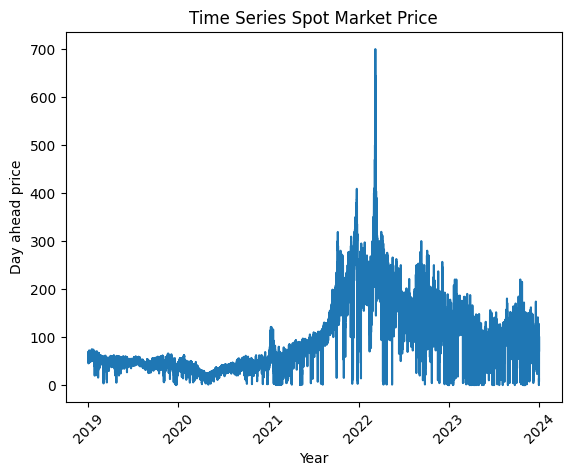

In [12]:
# Display a plot where for the evolution of the price
plt.plot(price_data)
plt.xlabel("Year")
plt.ylabel("Day ahead price")
plt.title("Time Series Spot Market Price")
plt.xticks(rotation=45)
plt.show()

In [13]:
# It seems to be a seasonal pattern (probabily daily one due to the nature of the data), as the curve move upwards and downwards fastly.
# Impossible to extract any clear conclusion, so reduce the ploted curve
# Just keep the data for the first month and for the first 10 days
price_data_jan2019 = price_data.iloc[0:744,]
price_data_10djan2019 = price_data.iloc[0:240,]

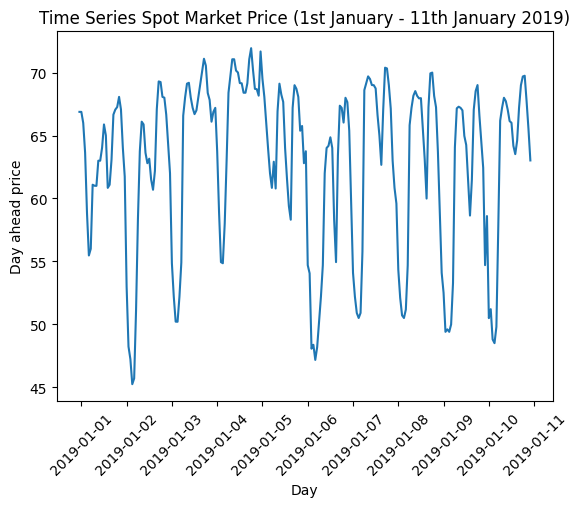

In [14]:
# Display a plot where for the evolution of the price first 10 days
plt.plot(price_data_10djan2019)
plt.xlabel("Day")
plt.ylabel("Day ahead price")
plt.title("Time Series Spot Market Price (1st January - 11th January 2019)")
plt.xticks(rotation=45)
plt.show()

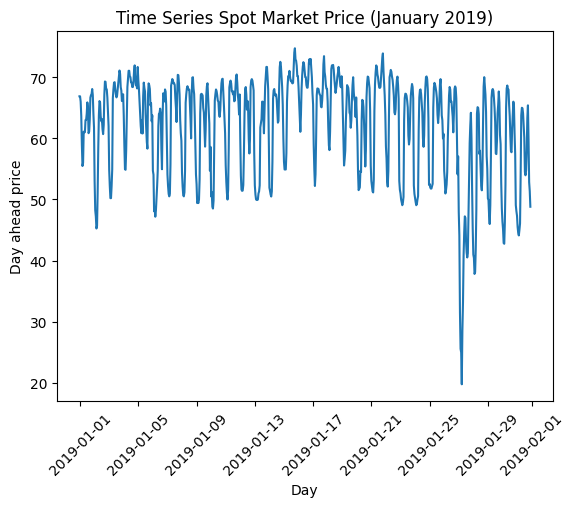

In [15]:
# Display a plot where for the evolution of the price for the first month
plt.plot(price_data_jan2019)
plt.xlabel("Day")
plt.ylabel("Day ahead price")
plt.title("Time Series Spot Market Price (January 2019)")
plt.xticks(rotation=45)
plt.show()

From the graph we may suspect the existance of seasonality, because a clear pattern can be distinguised. The pattern concerns daily seasonality, being the electricity price lower when the households are slept (midnight), bit greater when the people tend to wake up (7-8h). Later on, at the hours that there is sunlight (mornings-afternoon) it decreases a bit and reach its maximum where the people are awake and there is not sunight (evening-night).

The fact that prices have peridods of sharp increase has to do with the demand and supply rule. Probably, the demand does not change that much from one year after the other, to explain alone such sharp increases like the one in March 2022, so the supply plays a crucial role. Even in times where the supply is low, if the demand is low, like at midnight, the price will be low. But if the demand is high, the price will be high, greater than if the supply was higher.

The crisis of supplies caused by the start of the Ukranian-Russian war has as one of the causes the increase of the electricity price. Multiple reasons explain this increase, but the importance of Russian exports specially on raw materials that were used in the generation of the electricity is the main one.

Due to the great deal of data of the database, we will decompose the time series into years, months and days, as we are not able to extract insights about the seasonality.

In [16]:
# We split the database so as to easily access data regarding different time intervals
price_data["year"] = price_data.index.year
price_data["month"] = price_data.index.month
price_data["day"] = price_data.index.day
price_data["hour"] = price_data.index.hour

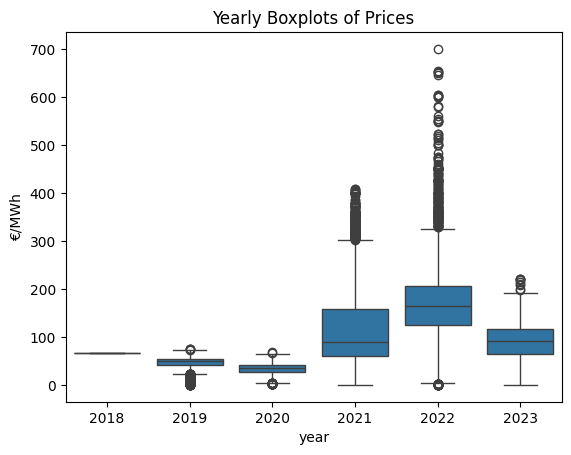

In [17]:
# We can summarize yearly data
sns.boxplot(data=price_data, x="year", y="price")
plt.title("Yearly Boxplots of Prices")
plt.ylabel("€/MWh")
plt.show()

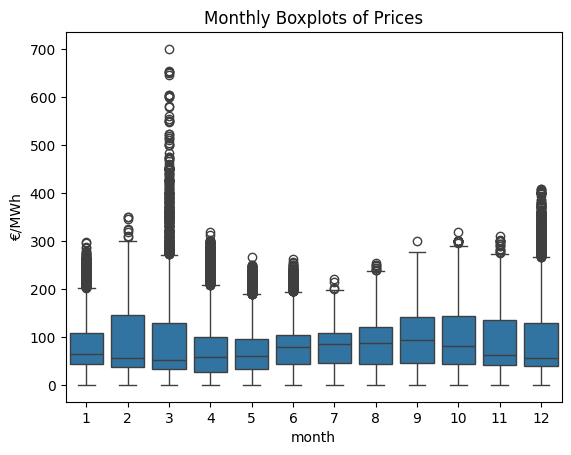

In [18]:
# We can monthly data
sns.boxplot(data=price_data, x="month", y="price")
plt.title("Monthly Boxplots of Prices")
plt.ylabel("€/MWh")
plt.show()

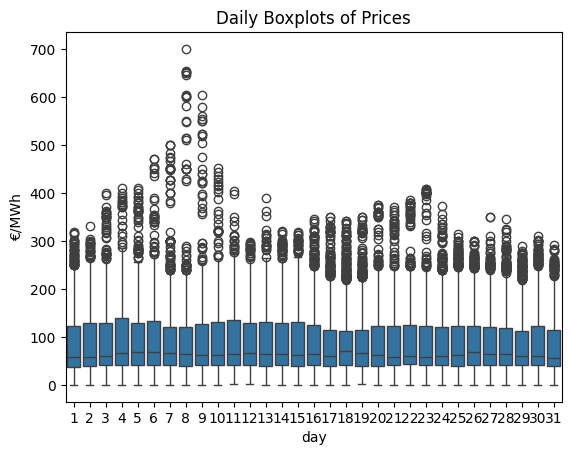

In [19]:
# We can see daily data
sns.boxplot(data=price_data, x="day", y="price")
plt.title("Daily Boxplots of Prices")
plt.ylabel("€/MWh")
plt.show()

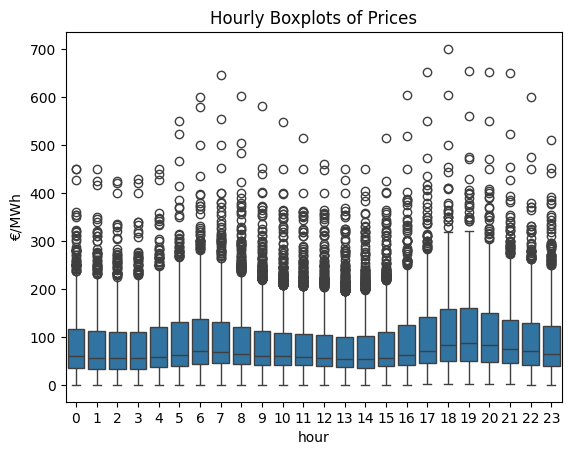

In [20]:
# We can see hourly data
sns.boxplot(data=price_data, x="hour", y="price")
plt.title("Hourly Boxplots of Prices")
plt.ylabel("€/MWh")
plt.show()

No information can be extracted from the last graph. Only the idea that the outliers, occured in the days 6,7, 8 and 9.

Regarding the monthly information, we can see that the outliers occured in the month of March plus the information of the years, we conclude is March 2022, the start of the war. Moreover, we can see that the median is greater in summer months (June, July and August) and in September than in winter ones. This can be explained by both the demand and supply. Regarding the demand, despite having more sunlight, the usage of different devices, such as coolers is much higher due to the increase in temperatures. Whereas, in the supply, the fact that there is more sunlight and elecricity production can increase amy be compensated by the decrease of production via hydropower or wind. In consequence, the possible increase in demand plus the possible decrease in supply may lead to a price increase.

It is worth to mention that winter months have greater variability, having more outliers that exceed the upper limit.

Finally, regarding year information, the main conclusion that can be extracted is the fact that the interquantile range is greater for 2021 and 2022, also the median is higher for this years. The IQR is very low for 2019 and 2020.

In [21]:
# Reset the data to only include the price value and the data. Latter as index
price_data = price_data[["price"]]

Now, we will decompose the time series, looking for seasonality, trends and levels.

The fact that the seasonality is roughly constant along the time series, let us suspect that the model is additive and not multiplicative.

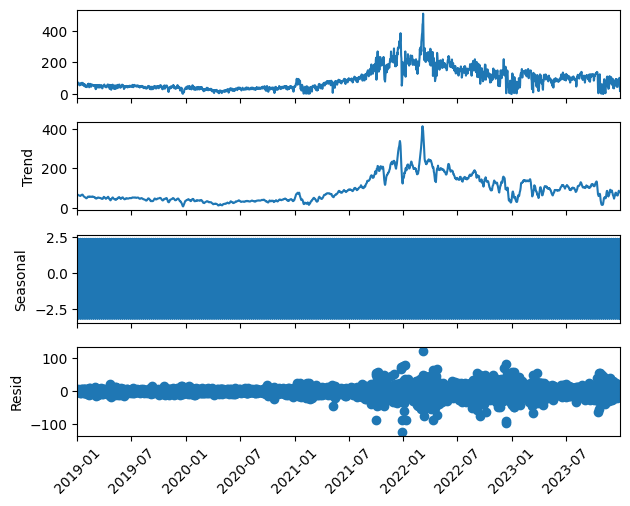

In [22]:
# Ensure that the frequency of the index is set (daily)
price_data_freq = price_data.asfreq('D')

# Decompose the time series
decompose_ts = seasonal_decompose(price_data_freq, model="additive")
decompose_ts.plot()
plt.xticks(rotation=45)
plt.show()

When it comes to the trend, the most impressive part is the huge increase of prices since the beggining of 2021 until the second quarter of 2022. Accommpained by a fierce decrease during the rest of the year. Since then, during the last year, the trend of the price has mantained quite constant (we are not including here the seasonality component). In consequence, we may not conclude that there exists a trend, it seems to be stationary.

Due to the great deal of data in the price_data set, the seasonal graph is unredable and none conclusion can be extracted. Therefore, despite we amy loss the intuition of monthly and yearly seasonality we decompose just the first month data trying to confirm our intuition of daily seasonality.

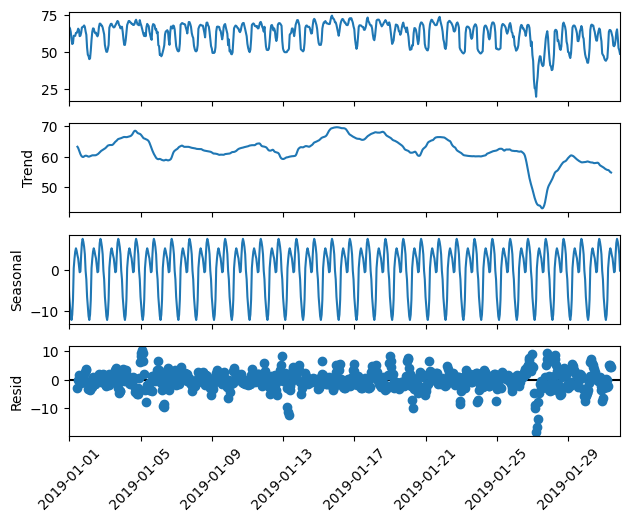

In [23]:
# Decompose first month of the time series
decompose_ts_jan19 = seasonal_decompose(price_data_jan2019, model="additive")
decompose_ts_jan19.plot()
plt.xticks(rotation=45)
plt.show()

We may confirm daily seasonality, as every day, the price in the seasonal graph start at a very low point, then increases sharply, decreases a bit prior to another rise and finally decreases sharply to a point near the starting one.

## Split the dataset

The split of the data into train and test would be done after the pre-processing. Something that could not have done if the database would have required pre-processing actions such as imputation, scaling or feature selection, that may lead to **data-leakage**. Data-leakage occurs when the researcher carry out pre-processing actions defined above prior to spliting the data, implying that the test data affect indirectly the model composition. The latter implies that the model evaluation would be too optimistic.

However, this would not occur in our model as none of the aforementioned pre-processing task must be accomplish.

Our data is non independent, it has a temporal order, so we have to be careful when splitting the dataset. This split will not be random, first observation, older ones will be in the training set and newer ones will be in the test part. To create a representative partition of the problem, we have decided that the training part will be 80% of the dataset, and the test part will be the remaining 20%. As we have data for 5 complete years, first 4 will go for train and the last for test.

In [24]:
# Ensure that the dataset is ordered by datetime
price_data = price_data.sort_index()

In [25]:
# How many years goes to test?
split_index = 8759

# Split train and test
data_train = price_data[0:-split_index] # Corresponds to the year 2019-2022 (both included).
data_test = price_data[-split_index:] # Corresponds to the last year, 2023.

Once we have the data splitted we will use train database, past evolution of data, to forecast its future values. We will forecast the observations corresponding with the test data using techniques, so afterwards we can compare the predictions with metrics such as the mean square error.

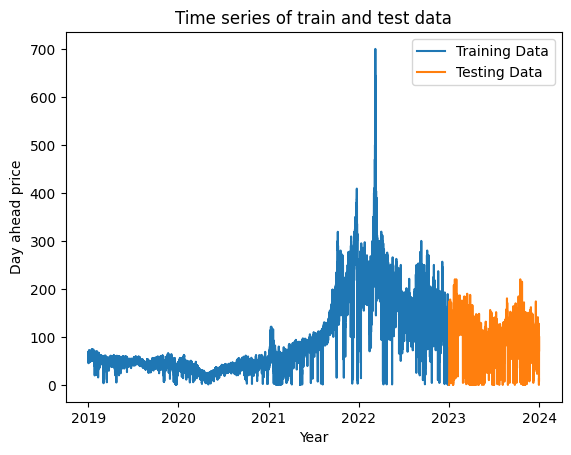

In [26]:
# Plot training and testing data
plt.plot(data_train, label="Training Data")
plt.plot(data_test, label="Testing Data")
plt.xlabel("Year")
plt.ylabel("Day ahead price")
plt.title("Time series of train and test data")
plt.legend()
plt.show()

## ARIMA analysis

In this section the goal is to seek the best ARIMA model according to our data. Different functions exist for this purpose, using different metrics such as the AIC, BIC... However, we consider important to first get a look at the ACF and PACF to try to guess the parameters using both graphs.

On the one hand, the former provides information regarding the values of the **number of lags** in the MA part, parameter q.

On the other hand, the later provides information regarding the values of the **number of lags** in the AR part, parameter p.

Autoregressive (AR) model forecast the response value using linear combination of previously observed. It has the following formula:
$
X_t = c + \phi_1 X_{t-1} + \phi_2 X_{t-2} + \ldots + \phi_p X_{t-p} + \varepsilon_t
$

The goal is to estimate $\phi$ coefficients and obtain the most suitable order, the value of p.

Moving Average (MA) model forecast the response variable using past forecast errors. It has the following formula:

$
X_t = \mu + \varepsilon_t + \theta_1 \varepsilon_{t-1} + \theta_2 \varepsilon_{t-2} + \ldots + \theta_q \varepsilon_{t-q}
$

The goal is to estimate $\theta$ coefficients and obtain the most suitable number of lags to be included, the value of q.

### Check the stationarity of the series:

First is important to define what is a stationary series. 3 different characteristics summarize this concept:

- Constant mean.
- Constant variance.
- Lack of seasonality.

The requirement of stationarity relies on the idea that the data belongs to the same distribution to latter use estimation techniques, such as MLE or OLS, which will make the predictions reliable.

Perform the Aumented Dicky-Fuller test to check the stationarity.
This test statistic is based on an hypothesis test, where the null-hypothesis is that the temporal series has a unit root, whereas the alternative hypothesis claims that the root is not unitary. Therefore, the null-hypothesis implies that the series is not stationary and the alternative hypothesis implies stationary series.
For rejecting the null hypothesis, the p-value should be lower than 0.05. The p-value is one of the four parameters that can be extracted through the "adfuller" from the statsmodel library.

In [27]:
# Perform the Aumented Dicky-Fuller test to confirm the stationarity
dicky_fuller_result = adfuller(data_train)
print('p-value: %f' % dicky_fuller_result[1])

p-value: 0.000254


We reject the null hypothesis. Therefore, the series is stationary, it is not required to compute the difference, d=0, as the series may not have a unit root. Probably, this is explained by the lack of trend during the years 2019 and 2020.

Another test, with the same goal is Kwiatkowski-Phillips-Schmidt-Shin (KPSS) test. However, in this one, the hypothesis are inverted, null-hypothesis claims that the series is stationary, whereas the alternative hypothesis claims that the series is not stationary. Consequenlty, we expect the p-value to be greater than 0.05, so the null-hypothesis is not rejected.

In [28]:
# Perform the KPSS test to confirm the stationary
kpss_result = kpss(data_train)
print('p-value: %f' % kpss_result[1])

p-value: 0.010000


<ipython-input-28-028632e031f4>:2: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_result = kpss(data_train)


However, this is not the case and the p-value is lower than 0.05, so this test suggest that there series is not-stationary. This result can be explained by the years 2021 and 2022, where an initial positive trend exist until April of 2022, and since then a negative trend occurs.

Therefore, the results are contradictory. What can be done now? We have to rely on our intuition, looking at the original series and the ACF and PACF plots.

### ACF (Autocorrelation function) and PACF (Partial autocorrelation function):

ACF calculates the correlation between a present value of the temporal series and their lags. ACF values can be in a range of -1 and 1, being 1 a perfectly positive correlation with that lag, 0 no correlation and -1 a perfectly negative correlation. These values are represented in the Y axis, whereas the X-axis represents the lag.

As it is known, MA claims that the number of lags is finite, the number of lags can be approximated in the graph looking at the point where the function drops sharply. How would we know weather this drop is enough? The significant lags are those out of the confidence interval ploted in blue in the graph.

Regarding the seasonality issue, is worth to mention that:

- We can see seasonality through the ACF if we find correlation at certain lag multiples is in general higher than others.
- We can see a trend through the ACF if correlation for recent lags is very high and slowly decreases as lags increase.

PACF measures the correlation between the acutal observation and the lag, after removing the effect of the intermediate lags. Consequently, it quantifies the direct influence of each lag on the current observation, holding constant the influence of all intermediate lags. For example the PACF for lag 2 is only the correaltion that lag 1 did not explain.

Like the ACF, the PACF ranges from -1 to 1, being 1 perfectly positive correlation...

As expalined above, it helps identifying the order of the autoregressive (AR) component in an ARIMA model. Again check the first values out of the confidence interval to obtain this value. The sharper the decay, the lower the parameter will be.

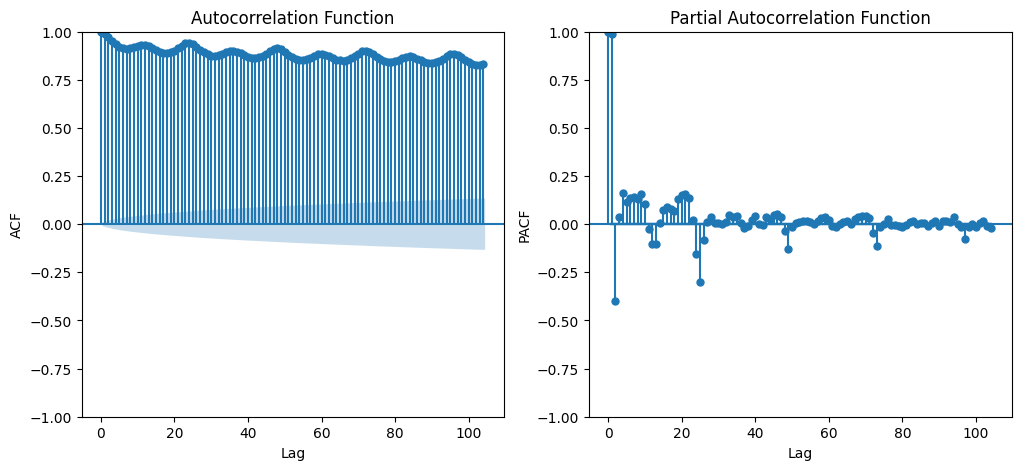

In [ ]:
# Create a figure and axes for both plots
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# Plot the ACF
plot_acf(data_train, lags=104, ax=axs[0])
axs[0].set_title('Autocorrelation Function')
axs[0].set_xlabel('Lag')
axs[0].set_ylabel('ACF')

# Plot the PACF
plot_pacf(data_train, lags=104, method='ywm', ax=axs[1])
axs[1].set_title('Partial Autocorrelation Function')
axs[1].set_xlabel('Lag')
axs[1].set_ylabel('PACF') # Despite not seeing the CI, it exist but is very low (we can see it if we set plt.ylim(-0.1, 0.1))

# Show the plots
plt.show()

The above graph may suggest an ARIMA (2,0,0) (2,0,0),24. Why?
There exist a decaying pattern in the ACF where all the lags are above the interval and very large and in the PACF only certain lags are truly significant, with a value greater than 0.25. This is typical of the AR models.

The p=2, comes from the fact that only lags 1 and 2 are greater than 0.25 in absolute terms, lags 3,4 are lower than 0.25.
The P=2, comes from the fact that lags 0 and 24 are greater than 0.25.

We have assumed that the confidence interval of the PACF must be around that value, 0.25.

However, one may think that the decay in the ACF is very low, suggesting the need to differenciate the series, as the trend occured in 2021 and 2022, is causing problems.

In [ ]:
# Take the difference data
data_train_diff = data_train.diff()

# However, there will be some observations (first ones) for which there is not previous hour observations
data_train_diff = data_train_diff.dropna()

NameError: name 'data_train' is not defined

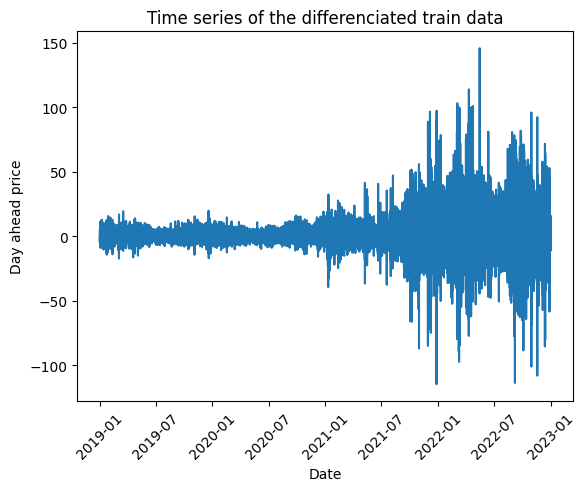

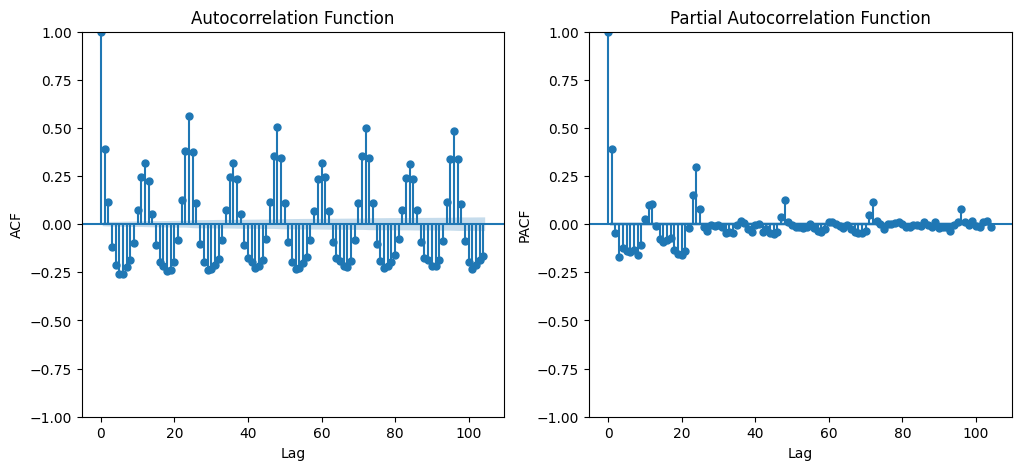

In [ ]:
# Plot the data
plt.plot(data_train_diff)
plt.xlabel("Date")
plt.ylabel("Day ahead price")
plt.title("Time series of the differenciated train data")
plt.xticks(rotation=45)
plt.show()

# Create a figure and axes for both plots
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# Plot the ACF
plot_acf(data_train_diff, lags=104, ax=axs[0])
axs[0].set_title('Autocorrelation Function')
axs[0].set_xlabel('Lag')
axs[0].set_ylabel('ACF')

# Plot the PACF
plot_pacf(data_train_diff, lags=104, method='ywm', ax=axs[1])
axs[1].set_title('Partial Autocorrelation Function')
axs[1].set_xlabel('Lag')
axs[1].set_ylabel('PACF') # Despite not seeing the CI, it exist but is very low (we can see it if we set plt.ylim(-0.1, 0.1))

# Show the plots
plt.show()

The best model according to the graphs is: ARIMA (1,1,0), (1,0,0), 24

Now clearly we can see from the time series plot the lack of constant variance and in the ACF and PACF the appearance of seasonality. We cannot deal with the variance, as the box cox requires positive values, which is not the case as we have taken the difference and some values are negative.

Even if now is stationary accoirding to both test.

In [ ]:
# Use BoxCox transformation to end up having constant variance
#data_train_diff2, lam = boxcox(data_train_diff.squeeze())

# If lambda_value is close to 0, consider using log transformation instead
#if np.abs(lam) < 0.1:
#    data_train_diff2 = np.log(data_train_diff.squeeze())

# BOX-COX ONLY WORKS FOR POSITIVE VALUES (cannot apply the log to a negative value). THEREFORE IT MAKES NO SENSE TO USE IT HERE.

In [ ]:
# Seasonal adjustment:

# Remove daily seasonality, obtaining the value of each observation - last day observation
data_train_diff5 = data_train_diff.diff(periods=24) # Period=24, as the data is collected hourly

# However, there will be some observations (first ones) for which there is not previous day observations
data_train_diff5 = data_train_diff5.dropna()

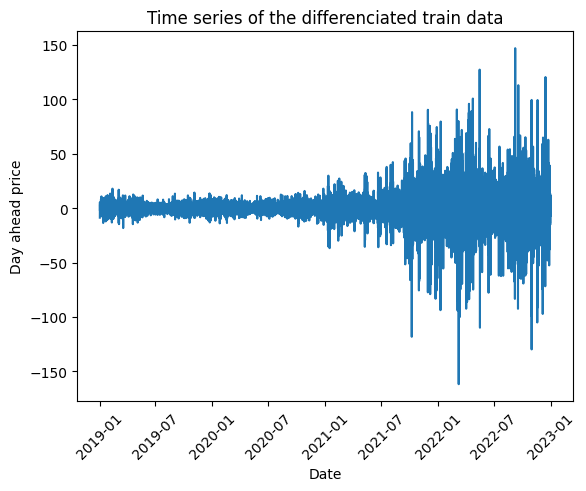

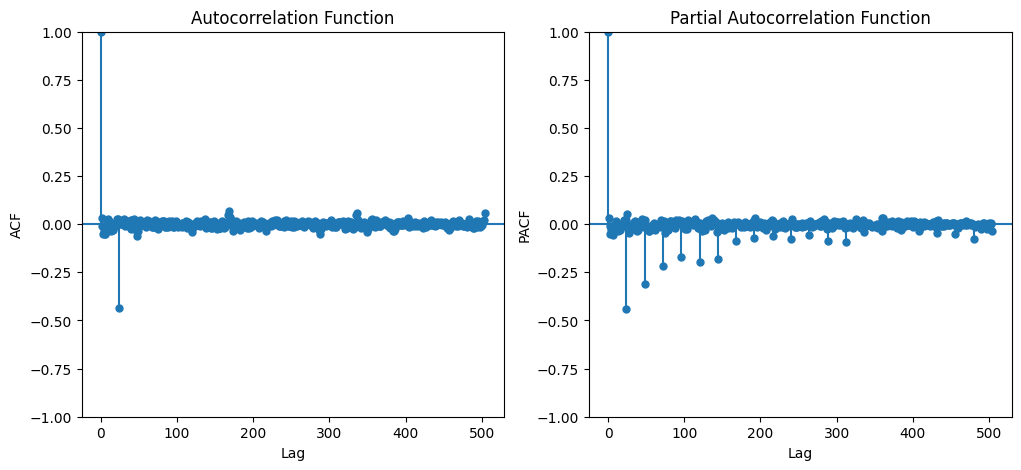

In [ ]:
# Plot the data
plt.plot(data_train_diff5)
plt.xlabel("Date")
plt.ylabel("Day ahead price")
plt.title("Time series of the differenciated train data")
plt.xticks(rotation=45)
plt.show()

# Create a figure and axes for both plots
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# Set ylim before plotting
ylim = (-0.1, 0.1)

# Plot the ACF
plot_acf(data_train_diff5, lags=504, ax=axs[0])
axs[0].set_title('Autocorrelation Function')
axs[0].set_xlabel('Lag')
axs[0].set_ylabel('ACF')
#axs[0].set_ylim(ylim)

# Plot the PACF
plot_pacf(data_train_diff5, lags=504, method='ywm', ax=axs[1])
axs[1].set_title('Partial Autocorrelation Function')
axs[1].set_xlabel('Lag')
axs[1].set_ylabel('PACF')
#axs[1].set_ylim(ylim)

# Show the plots
plt.show()

The best model is: ARIMA (0,1,0), (2,1,1), 24. Where the P parameter may go from 2 to 13 depending where we set the confidence interval.

**Other alternative:**

Now, instead of trying to fix first the trend, we opt for getting a constant variance.

In [27]:
# Suppress all warnings
warnings.filterwarnings("ignore")

# As the minimum price is zero and the log of 0 is cannot be computed:
data_train[data_train == 0] += 0.01

# Use BoxCox transformation to end up having constant variance
data_train_diff2, lam = boxcox(data_train.squeeze()) # Need to convert from df to 1-D array

# If lambda_value is close to 0, consider using log transformation instead
if np.abs(lam) < 0.1:
    data_train_diff2 = np.log(data_train.squeeze())

# Convert the data back to dataframe
data_train_diff2 = pd.DataFrame(data_train_diff2)

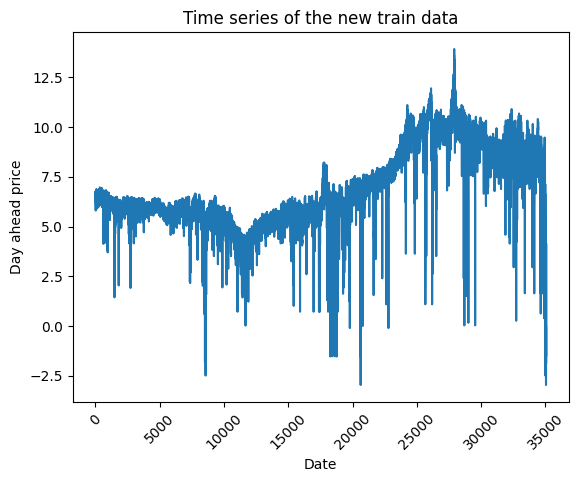

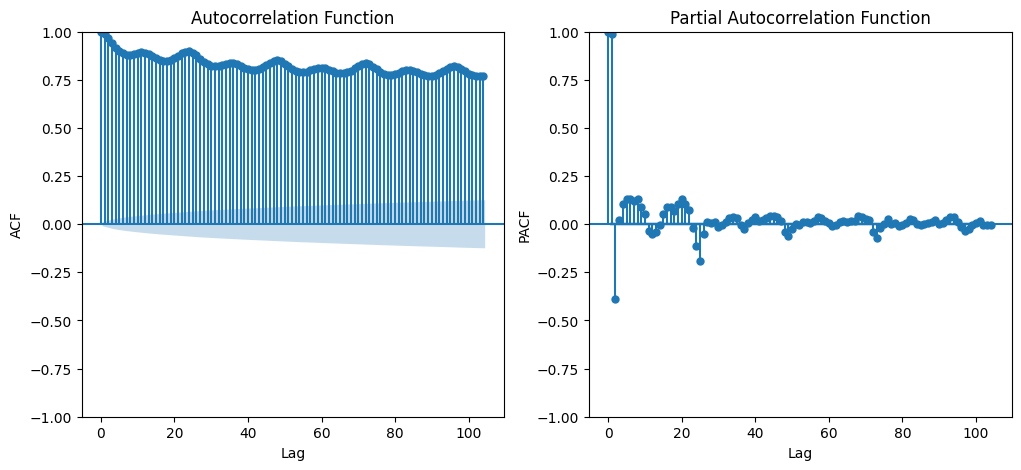

In [ ]:
# Plot the data
plt.plot(data_train_diff2)
plt.xlabel("Date")
plt.ylabel("Day ahead price")
plt.title("Time series of the new train data")
plt.xticks(rotation=45)
plt.show()

# Create a figure and axes for both plots
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# Plot the ACF
plot_acf(data_train_diff2, lags=104, ax=axs[0])
axs[0].set_title('Autocorrelation Function')
axs[0].set_xlabel('Lag')
axs[0].set_ylabel('ACF')

# Plot the PACF
plot_pacf(data_train_diff2, lags=104, method='ywm', ax=axs[1])
axs[1].set_title('Partial Autocorrelation Function')
axs[1].set_xlabel('Lag')
axs[1].set_ylabel('PACF') # Despite not seeing the CI, it exist but is very low (we can see it if we set plt.ylim(-0.1, 0.1))

# Show the plots
plt.show()

Now the most suitable model is: ARIMA (2,0,0), (1,0,0), 24

Once the problem of non-constant variance is solved, we must focus on the rest of the problems, the trend and the seasonality, to reach stationarity, as is not stationary yet.

In [28]:
# Take the difference data
data_train_diff3 = data_train_diff2.diff()

# However, there will be some observations (first ones) for which there is not previous hour observations
data_train_diff3 = data_train_diff3.dropna()

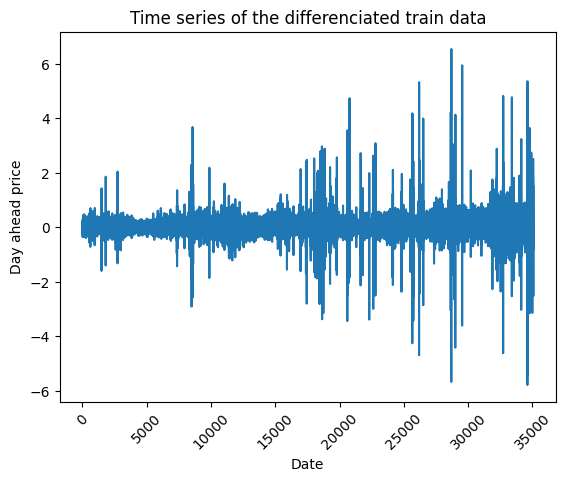

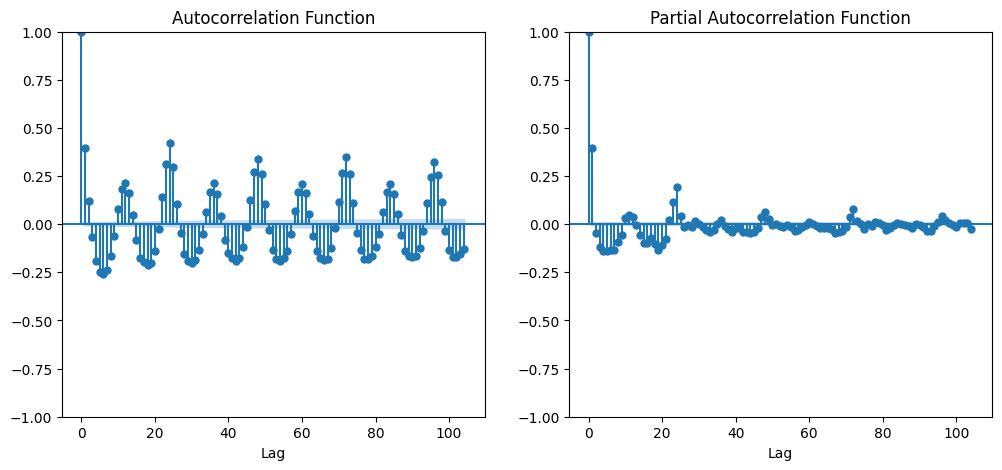

In [ ]:
# Plot the data
plt.plot(data_train_diff3)
plt.xlabel("Date")
plt.ylabel("Day ahead price")
plt.title("Time series of the differenciated train data")
plt.xticks(rotation=45)
plt.show()

# Create a figure and axes for both plots
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# Plot the ACF
plot_acf(data_train_diff3, lags=104, ax=axs[0])
axs[0].set_title('Autocorrelation Function')
axs[0].set_xlabel('Lag')
#axs[0].set_ylabel('ACF')

# Plot the PACF
plot_pacf(data_train_diff3, lags=104, method='ywm', ax=axs[1])
axs[1].set_title('Partial Autocorrelation Function')
axs[1].set_xlabel('Lag')
#axs[1].set_ylabel('PACF') # Despite not seeing the CI, it exist but is very low (we can see it if we set plt.ylim(-0.1, 0.1))

# Show the plots
plt.show() # Now it is stationary

Here the most suitable model is: ARIMA (1,1,0), (1,0,0), 24

Finally, remove the seasonality through the differenciation of the observations with respect their previous day value.

In [29]:
# Seasonal adjustment:

# Remove daily seasonality, obtaining the value of each observation - last day observation
data_train_diff4 = data_train_diff3.diff(periods=24) # Period=24, as the data is collected hourly

# However, there will be some observations (first ones) for which there is not previous day observations
data_train_diff4 = data_train_diff4.dropna()

In [ ]:
data_train_diff4.index = data_train.index[-len(data_train_diff4):]

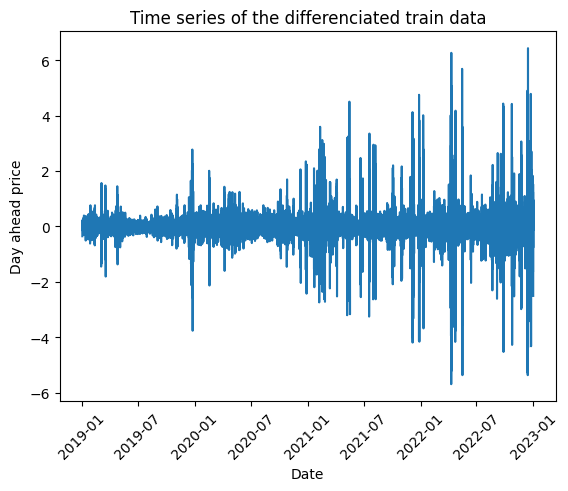

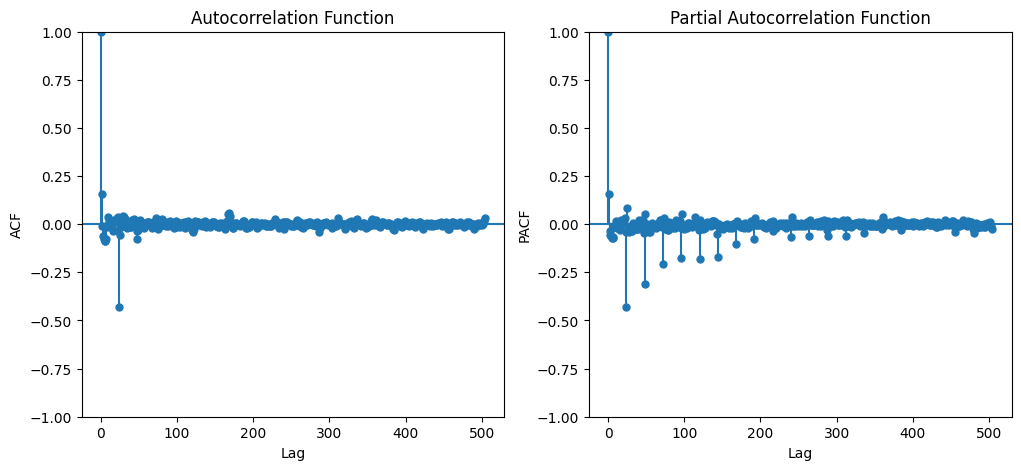

In [ ]:
# Plot the data
plt.plot(data_train_diff4)
plt.xlabel("Date")
plt.ylabel("Day ahead price")
plt.title("Time series of the differenciated train data")
plt.xticks(rotation=45)
plt.show()

# Create a figure and axes for both plots
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# Set ylim before plotting
ylim = (-0.1, 0.1)

# Plot the ACF
plot_acf(data_train_diff4, lags=504, ax=axs[0])
axs[0].set_title('Autocorrelation Function')
axs[0].set_xlabel('Lag')
axs[0].set_ylabel('ACF')
#axs[0].set_ylim(ylim)

# Plot the PACF
plot_pacf(data_train_diff4, lags=504, method='ywm', ax=axs[1])
axs[1].set_title('Partial Autocorrelation Function')
axs[1].set_xlabel('Lag')
axs[1].set_ylabel('PACF')
#axs[1].set_ylim(ylim)

# Show the plots
plt.show()

Here, the best model would be: ARIMA (1,1,1), (2,1,1), 24. Where the P parameter can oscilate from 2 to 7.

**Other alternative:**

Deal first with the seasonality.

In [ ]:
# Seasonal adjustment:

# Remove daily seasonality, obtaining the value of each observation - last day observation
data_train_diff6 = data_train.diff(periods=24) # Period=24, as the data is collected hourly

# However, there will be some observations (first ones) for which there is not previous day observations
data_train_diff6 = data_train_diff6.dropna()

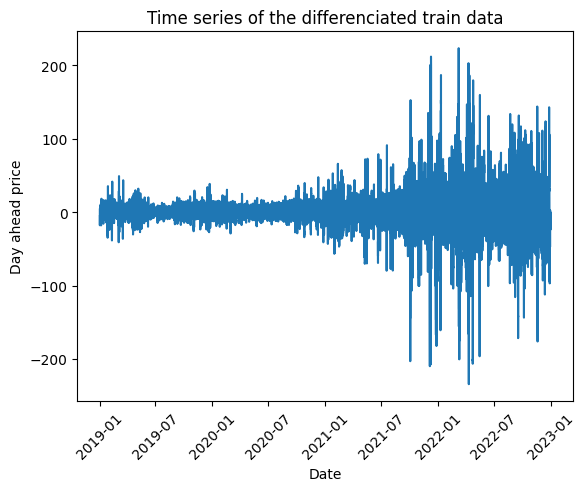

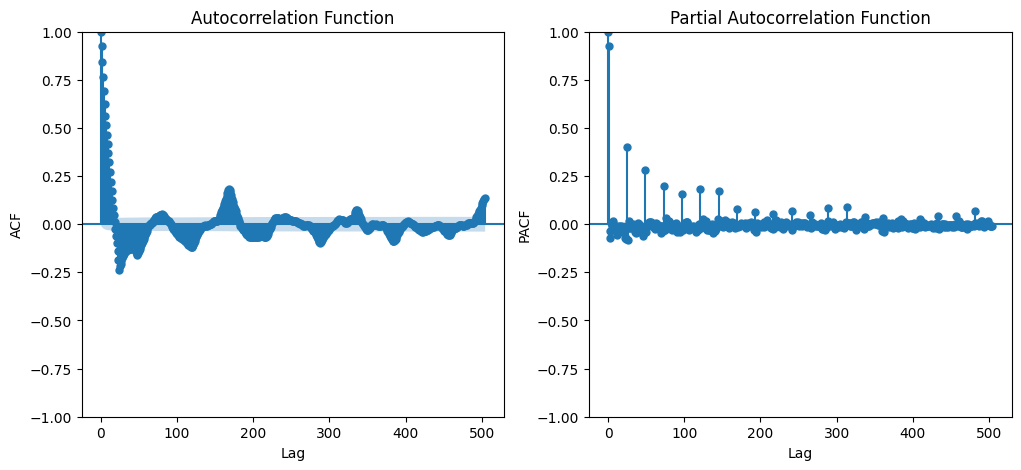

In [ ]:
# Plot the data
plt.plot(data_train_diff6)
plt.xlabel("Date")
plt.ylabel("Day ahead price")
plt.title("Time series of the differenciated train data")
plt.xticks(rotation=45)
plt.show()

# Create a figure and axes for both plots
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# Set ylim before plotting
ylim = (-0.1, 0.1)

# Plot the ACF
plot_acf(data_train_diff6, lags=504, ax=axs[0])
axs[0].set_title('Autocorrelation Function')
axs[0].set_xlabel('Lag')
axs[0].set_ylabel('ACF')
#axs[0].set_ylim(ylim)

# Plot the PACF
plot_pacf(data_train_diff6, lags=504, method='ywm', ax=axs[1])
axs[1].set_title('Partial Autocorrelation Function')
axs[1].set_xlabel('Lag')
axs[1].set_ylabel('PACF')
#axs[1].set_ylim(ylim)

# Show the plots
plt.show()

The model that illustrates the above graphs is: ARIMA (1,0,0), (1,1,0), 24. Where the P can go in a range between 1 and 6 depending on where we set the confidence interval.

In [ ]:
# Take the difference data
data_train_diff7 = data_train_diff6.diff()

# However, there will be some observations (first ones) for which there is not previous hour observations
data_train_diff7 = data_train_diff7.dropna()

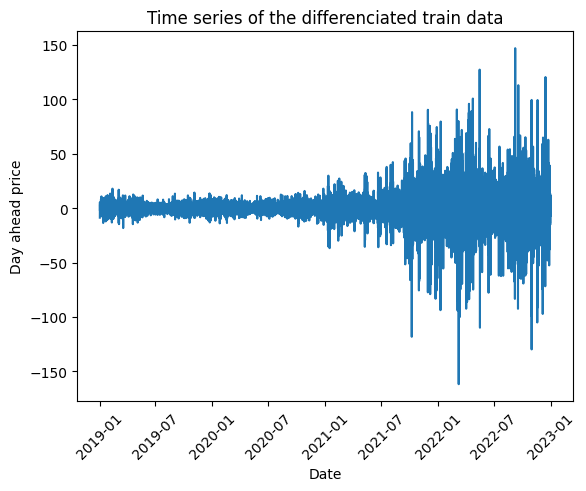

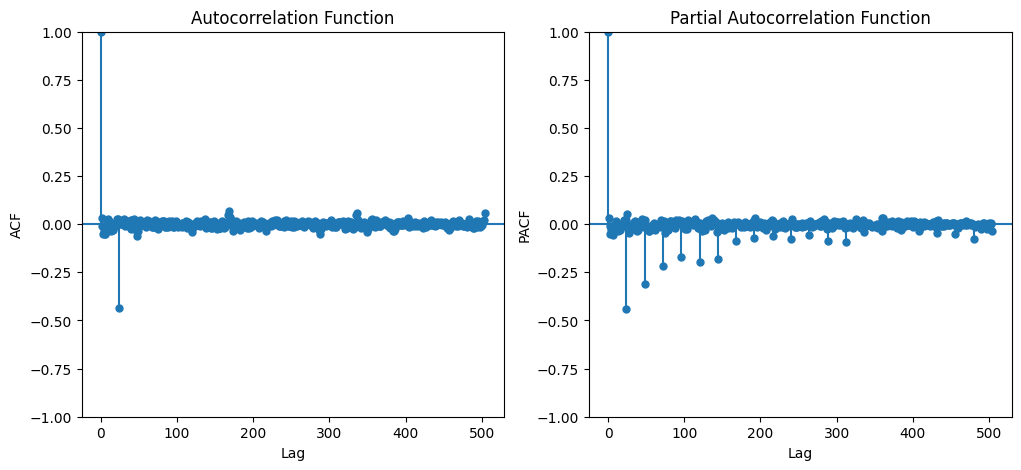

In [ ]:
# Plot the data
plt.plot(data_train_diff7)
plt.xlabel("Date")
plt.ylabel("Day ahead price")
plt.title("Time series of the differenciated train data")
plt.xticks(rotation=45)
plt.show()

# Create a figure and axes for both plots
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# Set ylim before plotting
ylim = (-0.1, 0.1)

# Plot the ACF
plot_acf(data_train_diff7, lags=504, ax=axs[0])
axs[0].set_title('Autocorrelation Function')
axs[0].set_xlabel('Lag')
axs[0].set_ylabel('ACF')
#axs[0].set_ylim(ylim)

# Plot the PACF
plot_pacf(data_train_diff7, lags=504, method='ywm', ax=axs[1])
axs[1].set_title('Partial Autocorrelation Function')
axs[1].set_xlabel('Lag')
axs[1].set_ylabel('PACF')
#axs[1].set_ylim(ylim)

# Show the plots
plt.show()

The best model here would be ARIMA(0,1,0), (2,1,1), 24. Where the P can oscilate in a range from 2 to 13 lags, depending on where we set the confidence intervals.

### Auto Arima function:

Apart from the models obtained through the above graphs, we will use the autoarima function for obtaining the most suitable model according to AIC and BIC.

In [ ]:
# Auto Arima function
model = auto_arima(data_train.iloc[27719:28463,], seasonal=True,  start_p=0, d=0, start_q=0, max_p=5, max_d=3, max_q=5, start_P=0, D=0, start_Q=0, max_P=5, max_D=3,max_Q=5, m=24, suppress_warnings=True, stepwise=True)

In [ ]:
model
# For the last 2 months of 2022 (November and Dicember)
# data_train.iloc[33597:35061,]
# ARIMA (2,0,0), (2,0,0), 24

# For the first 2 months of 2019 (January and February)
# data_train.iloc[:1416,]
# ARIMA (2,0,0), (2,0,0), 24

# For August and September of 2021
# data_train.iloc[22632:24096,]
# ARIMA (2,0,0), (2,0,0), 24

# We get the same ARIMA model for all but for:

# For March of 2022 (Most expensive period)
# data_train.iloc[27719:28463,]
# ARIMA (2,0,0), (2,0,1), 24, where the model does not differ so much.

ARIMA(order=(2, 0, 0), scoring_args={}, seasonal_order=(2, 0, 1, 24),
      suppress_warnings=True)

### Selection of the best model:

To sum up, we have the supposition of 5 models, as many were repeated. To pick up the best one, we will not guide ourselves with the auto arima function, as just 2 months can be included as data, but with AIC which works behind the auto arima but with larger time periods.

In [ ]:
data_train.index = pd.DatetimeIndex(data_train.index).to_period('h')

<ipython-input-26-63cba413ca05>:1: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  data_train.index = pd.DatetimeIndex(data_train.index).to_period('h')


In [ ]:
data_2122 = data_train.iloc[17543:,]
data_2122

,price
datetime,
2020-12-31 23:00,50.87
2021-01-01 00:00,48.19
2021-01-01 01:00,44.68
2021-01-01 02:00,38.50
2021-01-01 03:00,36.80
...,...
2022-12-31 18:00,18.11
2022-12-31 19:00,7.60
2022-12-31 20:00,3.69


In [ ]:
print(data_2122.index.freq)

<Hour>


In [ ]:
model = ARIMA(data_2122, order=(2,0,0), seasonal_order=(2,0,0,24))

In [ ]:
model_fit = model.fit()  # Fit the model

In [ ]:
model_fit.aic

134335.78922893465

In [ ]:
model = ARIMA(data_2122, order=(1, 1, 0), seasonal_order=(1, 0, 0, 24))

In [ ]:
model_fit = model.fit()  # Fit the model

In [ ]:
model_fit.aic

136080.03302698585

In [ ]:
model = ARIMA(data_2122, order=(0, 1, 0), seasonal_order=(2, 1, 1, 24))

In [ ]:
model_fit = model.fit()  # Fit the model

In [ ]:
model_fit.aic

131860.37764082695

In [ ]:
model = ARIMA(data_2122, order=(2, 0, 0), seasonal_order=(1, 0, 0, 24))

In [ ]:
model_fit = model.fit()  # Fit the model

In [ ]:
model_fit.aic

135670.98675784524

In [ ]:
model = ARIMA(data_2122, order=(1, 1, 1), seasonal_order=(2, 1, 1, 24))

In [ ]:
model_fit = model.fit()  # Fit the model

In [ ]:
model_fit.aic

131735.40607205755

In [ ]:
model = ARIMA(data_2122, order=(1, 0, 0), seasonal_order=(2, 1, 0, 24))

In [ ]:
model_fit = model.fit()  # Fit the model

In [ ]:
model_fit.aic

134661.20268263467

Now, we calculate the AIC for a N(90.24,74.28), which are the parameters of the trained data, the mean and the standard deviation, respectively. With the idea to see if it is a better model.

In [ ]:
# Mean and standard deviation of the normal distribution
mean = 90.242987
std = 74.281116

# Generate predictions from the normal distribution
predictions_normal = norm.rvs(loc=mean, scale=std, size=len(data_test))

# Calculate the log likelihood
log_likelihood = np.sum(norm.logpdf(data_test, loc=mean, scale=std))

# Number of parameters (mean and std)
k = 2

# Calculate the AIC
aic_normal = 2 * k - 2 * log_likelihood
print(f'AIC for the normal model (with all train info): {aic_normal}')


AIC for the normal model: 94295.89076749621


In [ ]:
# Mean and standard deviation of the normal distribution
mean = 139.74
std = 77.29

# Generate predictions from the normal distribution
predictions_normal = norm.rvs(loc=mean, scale=std, size=len(data_test))

# Calculate the log likelihood
log_likelihood = np.sum(norm.logpdf(data_test, loc=mean, scale=std))

# Number of parameters (mean and std)
k = 2

# Calculate the AIC
aic_normal = 2 * k - 2 * log_likelihood
print(f'AIC for the normal model (with only data from 2021 and 2022): {aic_normal}')


AIC for the normal model: 98830.39218710363


In [ ]:
# Fit a gamma distribution to the data
shape, loc, scale = gamma.fit(data_train['price'])

# Calculate the log-likelihood
log_likelihood = gamma.logpdf(data_train['price'], shape, loc=loc, scale=scale).sum()

# Calculate the number of parameters (shape, loc, scale)
n_params = 3

# Calculate AIC
aic_gamma = 2 * n_params - 2 * log_likelihood
print(f'AIC for the gamma model: {aic_gamma}')

AIC for the gamma model: 381266.7105686353


In [ ]:
# Log-normal distribution:

# Adjust prices that are 0 by adding 1 euro
data_train.loc[data_train['price'] == 0, 'price'] = 1

# Fit a log-normal distribution to the log-transformed data
log_data = np.log(data_train['price'])
shape, loc, scale = lognorm.fit(log_data)

# Calculate the log-likelihood
log_likelihood = lognorm.logpdf(log_data, shape, loc=loc, scale=scale).sum()

# Calculate the number of parameters (shape, loc, scale)
n_params = 3

# Calculate AIC
aic_lognorm = 2 * n_params - 2 * log_likelihood
print(f'AIC for the log-likelihood model: {aic_lognorm}')

AIC for the log-likelihood model: 91264.24736952865


/tmp/ipykernel_69833/174944618.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_train.loc[data_train['price'] == 0, 'price'] = 1
/home/javiergoni/miniconda3/envs/myenvjav/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:6545: RuntimeWarning: invalid value encountered in log
  lndata = np.log(data - loc)


We can check that both normal and specially, log-normal, are better models than ARIMA (1, 1, 1), (2, 1, 1), 24. Not the same conclusion can be added to the gamma distributuion, which is worst.

In [32]:
data_2122 = data_train.iloc[17543:,]

In [30]:
# Perform the Aumented Dicky-Fuller test to confirm the stationarity (data_train_diff4 is used as is the data associated with that)
dicky_fuller_result = adfuller(data_train_diff4)
print('p-value: %f' % dicky_fuller_result[1])

# Perform the KPSS test to confirm the stationary
kpss_result = kpss(data_train_diff4)
print('p-value: %f' % kpss_result[1])

p-value: 0.000000
p-value: 0.100000


We can now estimate the model parameters:

In [ ]:
# Confidence Interval

# Ignore all warnings
warnings.filterwarnings("ignore")

np.random.seed(123)
y = data_2122["price"]

## Block bootstrap:
blockLen = 24 # Length of each block. In our case daily blocks.
N = len(data_2122) # Length of the time series (just the train part)
blockNum = round(N / blockLen) # Number of blocks
betaBlock = [] # Empty list to store estimated parameters
for _ in range(10): # Generate 100 bootstrap samples
  start = np.random.choice(range(N - blockLen + 1), size=blockNum, replace=True) # Set the starting point for sampling (sampling with replacement as is bootstrap)
  blockedIndices = np.concatenate([np.arange(s, s + blockLen) for s in start]) # Bootstrap indices
  eso = y[blockedIndices] # Get the response variable for the above defined indices

  model = ARIMA(eso, order=(1, 1, 1), seasonal_order=(2, 1, 1, 24))
  model_fit = model.fit()
  betaBlock.append(model_fit.params[0])

betaBlock = np.array(betaBlock)

## Define the confidence intervals
conf_intervals = np.quantile(betaBlock, [0.025, 0.975])
print(f"95% Confidence Interval: {conf_intervals}")

In summary, we are 95% confident that the true value of the parameter associated with the ARIMA model falls within the range [0.56792938, 0.60441633]. This interval provides a measure of the uncertainty surrounding our estimate of the parameter.

In [ ]:
# Set the style of the seaborn plot
sns.set(style="whitegrid")

# Plot the density of betaBlock with seaborn
sns.kdeplot(betaBlock, color="pink", label="betaBlock", fill=True)

# Customizing the plot
plt.xlabel('') # Empty x-axis label as per the R code
plt.legend(title='Parameter', loc='upper right', labels=['betaBlock'])
plt.title('Density Plot of betaBlock')

# Show the plot
plt.show()

Use the Ljung-Box statistic for checking whether any of a group of autocorrelations of a time series are different from zero. It has a null hypothesis that claims that there are not autocorrelations in the residuals, so the model is adequate.

Is worth to remember that autocorrelation is the correlation, the linear relationship, between the function and the delayed version of the function.

Therefore, we need the p-value to be greater than 0.05 to confirm that the model is adequate.


In [33]:
# Fit the ARIMA model
model = ARIMA(data_2122, order=(1, 1, 1), seasonal_order=(2, 1, 1, 24))
model_fit = model.fit()

# Compute residuals
residuals = model_fit.resid

# Ljung-Box test
ljung_box_results = acorr_ljungbox(residuals, lags=[48], return_df=True) # Lags specify the nº of lags to test for autocorrelation (due to seasonality >24)
print("Ljung-Box test results:")
print(ljung_box_results)

Ljung-Box test results:
       lb_stat      lb_pvalue
48  747.786957  2.560498e-126


ARIMA makes assumptions about the distribution of the innovations. It assumes they are normally distributed with mean zero, we can easily check that visualizing the plots.

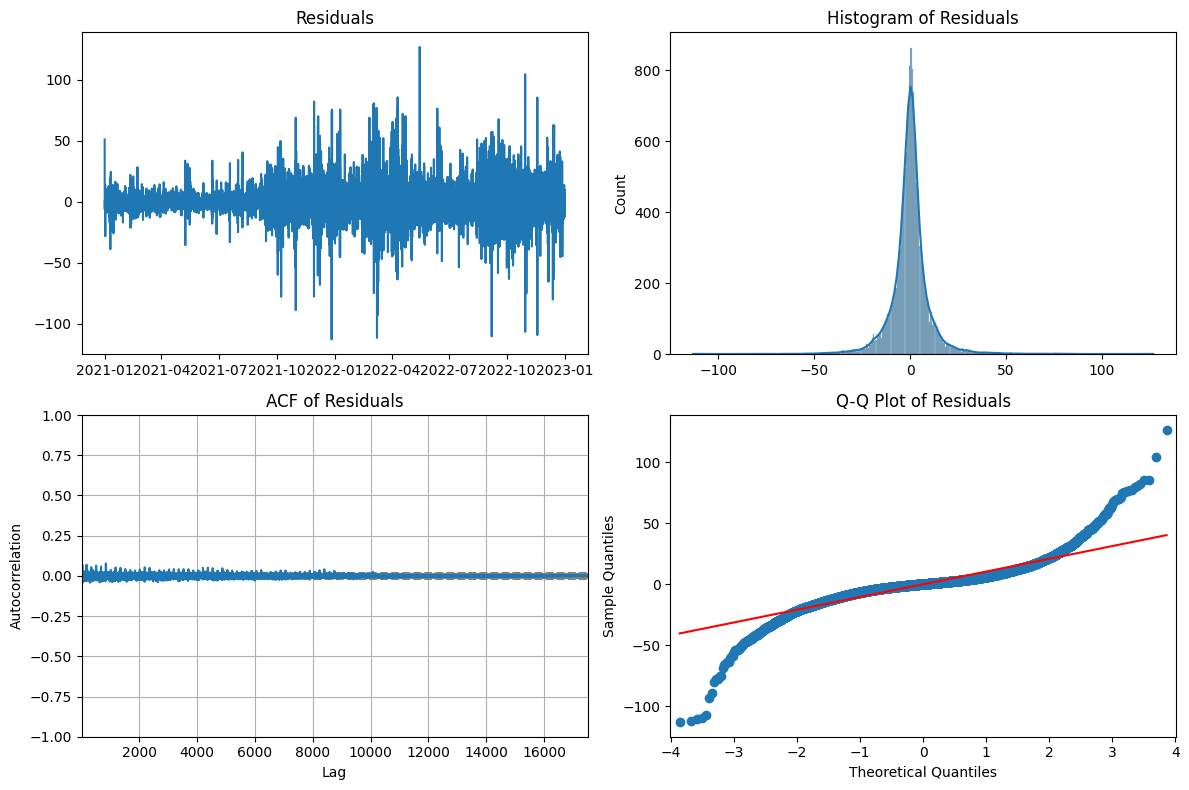

In [35]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from statsmodels.graphics.gofplots import qqplot

# Plot residuals
plt.figure(figsize=(12, 8))

# Residuals plot
plt.subplot(2, 2, 1)
plt.plot(residuals)
plt.title('Residuals')

# Histogram of residuals
plt.subplot(2, 2, 2)
sns.histplot(residuals, kde=True)
plt.title('Histogram of Residuals')

# ACF plot of residuals
plt.subplot(2, 2, 3)
pd.plotting.autocorrelation_plot(residuals)
plt.title('ACF of Residuals')

# Q-Q plot of residuals
plt.subplot(2, 2, 4)
qqplot(residuals, line='s', ax=plt.gca())  # Use statsmodels' qqplot function
plt.title('Q-Q Plot of Residuals')

plt.tight_layout()
plt.show()

### FORECASTING

The dates used for making the predictions are those of test, observations from 2023, so we can later compare both to see the accuracy of those predictions. We will add two different models because literature claims that are good for predicting, they are recurrent neural network (RNN) and Extreme gradient boosting.

In [ ]:
# Recurrent neural network (RNN)

# Feature engineering: create sequences for the RNN
def create_sequences(df, time_steps):
    sequences = []
    output = []
    for i in range(time_steps, len(df)):
        sequences.append(df[i-time_steps:i])
        output.append(df[i])
    return np.array(sequences), np.array(output)

np.random.seed(123)
# Normalize the data
scaler = MinMaxScaler()
data_train_scaled = scaler.fit_transform(data_train)
data_test_scaled = scaler.transform(data_test)

# Define the number of time steps (this is a hyperparameter you can tune)
time_steps = 24  # For example, 24-hour sequence for hourly data

# Create sequences for training and test data
X_train, y_train = create_sequences(data_train_scaled, time_steps)
X_test, y_test = create_sequences(data_test_scaled, time_steps)

# Define the RNN model (you can tune the number of units, layers, etc.)
rnn_model = Sequential()
rnn_model.add(SimpleRNN(units=50, input_shape=(X_train.shape[1], X_train.shape[2]), activation='relu'))
rnn_model.add(Dense(1))

# Compile the model with hyperparameters to tune (e.g., learning rate)
optimizer = Adam(learning_rate=0.001)
rnn_model.compile(optimizer=optimizer, loss='mean_squared_error')

# Train the model
np.random.seed(123)
rnn_model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2, verbose=1)

# Make predictions
np.random.seed(123)
predictions_rnn_scaled = rnn_model.predict(X_test)

# Inverse transform the predictions to the original scale
predictions_rnn = scaler.inverse_transform(predictions_rnn_scaled)

Epoch 1/10


/home/javiergoni/miniconda3/envs/myenvjav/lib/python3.9/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


876/876 ━━━━━━━━━━━━━━━━━━━━ 17s 18ms/step - loss: 0.0030 - val_loss: 7.7028e-04
Epoch 2/10
876/876 ━━━━━━━━━━━━━━━━━━━━ 14s 16ms/step - loss: 1.6105e-04 - val_loss: 5.8030e-04
Epoch 3/10
876/876 ━━━━━━━━━━━━━━━━━━━━ 14s 16ms/step - loss: 1.1518e-04 - val_loss: 4.7377e-04
Epoch 4/10
876/876 ━━━━━━━━━━━━━━━━━━━━ 14s 16ms/step - loss: 9.8546e-05 - val_loss: 4.8904e-04
Epoch 5/10
876/876 ━━━━━━━━━━━━━━━━━━━━ 16s 18ms/step - loss: 8.5251e-05 - val_loss: 4.1890e-04
Epoch 6/10
876/876 ━━━━━━━━━━━━━━━━━━━━ 17s 19ms/step - loss: 9.0475e-05 - val_loss: 4.2325e-04
Epoch 7/10
876/876 ━━━━━━━━━━━━━━━━━━━━ 15s 17ms/step - loss: 8.1277e-05 - val_loss: 4.1088e-04
Epoch 8/10
876/876 ━━━━━━━━━━━━━━━━━━━━ 22s 25ms/step - loss: 7.7329e-05 - val_loss: 4.5422e-04
Epoch 9/10
876/876 ━━━━━━━━━━━━━━━━━━━━ 18s 21ms/step - loss: 1.0269e-04 - val_loss: 4.1757e-04
Epoch 10/10
876/876 ━━━━━━━━━━━━━━━━━━━━ 16s 18ms/step - loss: 8.3634e-05 - val_loss: 4.2317e-04
273/273 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step


In [ ]:
# Check that the predictions are in the 2D
print(predictions_rnn.shape)

(8735, 1)


In [ ]:
# Convert into a 1D
predictions_rnn = predictions_rnn.flatten()

In [ ]:
# Incorporate a time series information to the prediction array
predictions_rnn = pd.Series(predictions_rnn, index=data_test.index[time_steps:])

In [ ]:
# Check if there are negative values
predictions_rnn.describe()

count    8735.000000
mean       85.525131
std        41.211987
min       -18.539051
25%        61.151730
50%        90.296478
75%       114.858654
max       234.079514
dtype: float64

In [ ]:
# Replace negative predictions with 0
predictions_rnn[predictions_rnn < 0] = 0

# Calculate the mse
mse_model_rnn = mean_squared_error(data_test[time_steps:], predictions_rnn)
print(f'MSE for the RNN: {mse_model_rnn}')

MSE for the RNN: 114.1697301089195


In [ ]:
# X-GBoost
# Feature engineering: create lagged features for the time series
def create_lagged_features(df, max_lag):
    for lag in range(1, max_lag + 1):
        df[f'lag_{lag}'] = df['price'].shift(lag)
    df.dropna(inplace=True)  # Drop rows with NaN values resulting from the shift operation

# Create copies of the original DataFrames to avoid modifying them
data_train_with_lags = data_train.copy()
data_test_with_lags = data_test.copy()

# Define the maximum number of lags
max_lag = 24  # 24-hour lag for hourly data

np.random.seed(123)
# Apply feature engineering to the training data
create_lagged_features(data_train_with_lags, max_lag)

# Prepare the data for XGBoost
X_train = data_train_with_lags.drop('price', axis=1)
y_train = data_train_with_lags['price']

# Hyperparameter tuning using GridSearchCV
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', seed=42)
parameters = {
    'n_estimators': [50, 100, 150],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2]
}
np.random.seed(123)
grid_search = GridSearchCV(estimator=xgb_model, param_grid=parameters, cv=3, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)

# Best model after hyperparameter tuning
best_xgb_model = grid_search.best_estimator_

# Feature engineering for the test data (using the same max_lag)
create_lagged_features(data_test_with_lags, max_lag)

# Prepare the test data for prediction
X_test = data_test_with_lags.drop('price', axis=1)

# Make predictions using the best model
np.random.seed(123)
predictions_xgb = best_xgb_model.predict(X_test)

In [ ]:
# Incorporate a time series information to the prediction array
predictions_xgb = pd.Series(predictions_xgb, index=data_test.index[time_steps:])

In [ ]:
# Get a first sight of the predictions
predictions_xgb.describe()

count    8735.000000
mean       87.742744
std        39.224720
min        -1.352578
25%        64.533157
50%        93.343811
75%       114.959763
max       222.719315
dtype: float64

In [ ]:
# Replace negative predictions with 0
predictions_xgb[predictions_xgb < 0] = 0

# Calculate the mse
mse_model_xgb = mean_squared_error(data_test[time_steps:], predictions_xgb)
print(f'MSE for the RNN: {mse_model_xgb}')

MSE for the RNN: 121.54044187677756


In [ ]:
######### Log-normal ##########

np.random.seed(123)
# Generate predictions from the fitted log-normal distribution for the length of the test set
log_predictions = lognorm.rvs(shape, loc=loc, scale=scale, size=len(data_test))

# Transform predictions back to the original scale
predictions_lognorm = np.exp(log_predictions)
predictions_lognorm = pd.Series(predictions_lognorm, index=data_test.index)
# Replace negative predictions with 0 (even if is not necessary here)
predictions_lognorm[predictions_lognorm < 0] = 0
mse_model_lognorm = mean_squared_error(data_test, predictions_lognorm)
print(f'MSE for the log-normal: {mse_model_lognorm}')

12398.493796461762

In [ ]:
######### GAMMA #########

np.random.seed(123)
# Generate predictions from the fitted gamma distribution for the length of the test set
predictions_gamma = gamma.rvs(shape, loc=loc, scale=scale, size=len(data_test))
predictions_gamma = pd.Series(predictions_gamma, index=data_test.index)
# Replace negative predictions with 0
predictions_gamma[predictions_gamma < 0] = 0
mse_model_gamma = mean_squared_error(data_test, predictions_gamma)
print(f'MSE for the gamma: {mse_model_gamma}')

9314.612304481841

In [ ]:
######### NORMAL #########
np.random.seed(123)
predictions = np.random.normal(90.24, 74.28, 8759) #8759=Nº of predictions to calculate (=data_test)
predictions_normal = pd.Series(predictions, index=data_test.index)
# Replace negative predictions with 0
predictions_normal[predictions_normal < 0] = 0
mse_model_N = mean_squared_error(data_test, predictions_normal)
print(f'MSE for the normal: {mse_model_N}')

MSE for the normal: 6316.788431483574


In [ ]:
######### ARIMA #########
model = ARIMA(data_2122, order=(1, 1, 1), seasonal_order=(2, 1, 1, 24))
model_fit = model.fit()
predictions1 = model_fit.predict(start=len(data_2122), end=len(data_2122)+len(data_test)-1, typ='levels') # Predict for the test

/home/javiergoni/miniconda3/envs/myenvjav/lib/python3.9/site-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['typ']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


In [ ]:
# Reverse Differencing Steps

# Step 1: Reverse Seasonal Differencing (assuming period=24 for daily seasonality in hourly data)
predictions_seasonal_reversed = []
for i in range(len(predictions1)):
    if i >= 24:
        val = predictions1.iloc[i] + data_2122.iloc[i-24]
    else:
        val = predictions1.iloc[i] + data_2122.iloc[i] # I have consider the idea of deleting those predictions, as was done when computing data_train_diff4. However, the alternative of adding the observation at i is another alternative, as it maintains the seasonality idea
        #val = NaN
    predictions_seasonal_reversed.append(val)
predictions_seasonal_reversed = pd.Series(predictions_seasonal_reversed, index=data_test.index)

# Step 2: Reverse Non-Seasonal Differencing
predictions_original_scale = []
for i in range(len(predictions_seasonal_reversed)):
    if i == 0:
        #val = predictions_seasonal_reversed.iloc[i] + data_22.iloc[-1]
        val = predictions_seasonal_reversed.iloc[i] + data_2122.iloc[i]
    else:
        val = predictions_seasonal_reversed.iloc[i] + predictions_original_scale[i - 1]
    predictions_original_scale.append(val)
predictions_original_scale = pd.Series(predictions_original_scale, index=data_test.index)

In [ ]:
mse_model_ARIMA = mean_squared_error(data_test, predictions_original_scale)
print(f'MSE for the best ARIMA: {mse_model_ARIMA}')

/home/javiergoni/miniconda3/envs/myenvjav/lib/python3.9/site-packages/sklearn/utils/_array_api.py:746: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  array = numpy.asarray(array, order=order, dtype=dtype)


13182497196133.283

The best models in terms of mean square error of predictions, by far are the RNN and the XGBoost. Bit better the RNN, so we opt for plotting it in comparison to the normal distribution used in similar papers.

We will now carry out a plot to compare the predictions with the test data, to see how well have it predict the reality.

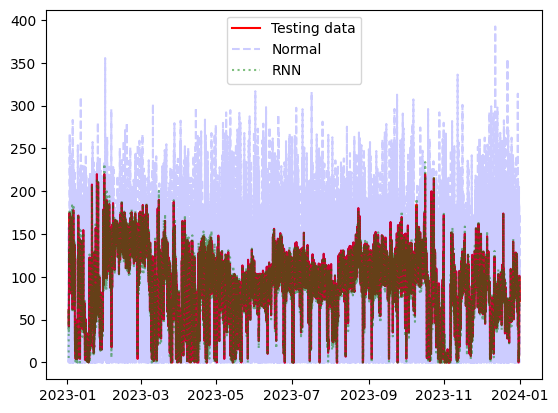

In [ ]:
# Plot the predictions and test data to evaluate the prediction
plt.plot(data_test.index[24:], data_test.values[24:], label='Testing data',color="red")
plt.plot(data_test.index[24:], predictions_normal[24:], label='Normal',color="blue", linestyle='--', alpha=0.2)
plt.plot(data_test.index[24:], predictions_rnn, label='RNN',color="green", linestyle=':', alpha=0.5)
plt.legend()
plt.show()

We can see that test and RNN tend to go always in the same direction. Therefore, those predictions are very good. See it with the train data as well:

In [ ]:
# Plot training and testing data
plt.plot(data_train, label="Training Data")
plt.plot(data_test, label="Testing Data")
plt.plot(data_test.index[24:], predictions_rnn, label='RNN',color="green", linestyle=':', alpha=0.5)
plt.xlabel("Year")
plt.ylabel("Day ahead price")
plt.title("Time series of train and test data")
plt.legend()
plt.show()